In [7]:
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.special import expit
import sys
import pandas as pd
import os
import struct

In [9]:
ds = load_digits()
X = ds.data/16.0-0.5 # normalize the input, very important
y = ds.target
X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size = 0.2)

params = dict(n_hidden=50, 
              C=0.1, # tradeoff L2 regularizer
              epochs=400, # iterations
              eta=0.001,  # learning rate
              random_state=1)

In [2]:
# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
# Start with the following functions:
#    init
#    encode_labels
#    initialize weights
#    sigmoid
#    add bias (vector of ones)
#    objective function (cost and regularizer)
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_) # reshape to be W
        b1 = np.zeros((self.n_hidden, 1))
        
        W2_num_elems = (self.n_hidden)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden)
        b2 = np.zeros((self.n_output_, 1))
        
        return W1, W2, b1, b2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_) * np.sqrt(np.mean(W1 ** 2) + np.mean(W2 ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term

In [3]:
# now let's add in the following functions:
#    feedforward
#    fit and predict
class TwoLayerPerceptron(TwoLayerPerceptronBase):
    def _feedforward(self, X, W1, W2, b1, b2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # need to vectorize this computation!
        # See additional code and derivation below!
        pass
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2, self.b1, self.b2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred
    
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.b1, self.b2 = self._initialize_weights()

        self.cost_ = []
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            # feedforward all instances
            A1, Z1, A2, Z2, A3 = self._feedforward(X_data,self.W1,self.W2, self.b1, self.b2)
            
            cost = self._cost(A3,Y_enc,self.W1,self.W2)
            self.cost_.append(cost)

            # compute gradient via backpropagation
            gradW1, gradW2, gradb1, gradb2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, Y_enc=Y_enc,
                                              W1=self.W1, W2=self.W2)

            self.W1 -= self.eta * gradW1
            self.W2 -= self.eta * gradW2
            self.b1 -= self.eta * gradb1
            self.b2 -= self.eta * gradb2
            

        return self

In [4]:
class TwoLayerPerceptronVectorized(TwoLayerPerceptron):
    # just need a different gradient calculation
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = -2*(Y_enc-A3)*A3*(1-A3)
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        
        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C * 2
        gradW2 += W2 * self.l2_C * 2 

        return gradW1, gradW2, gradb1, gradb2

In [5]:
class TLPVectorizedMiniBatch(TwoLayerPerceptronVectorized):
    def __init__(self, alpha=0.1, decrease_const=0.0, shuffle=True, minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
        
    def fit(self, X, y, print_progress=0):
        """ Learn weights from training data."""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.b1, self.b2 = self._initialize_weights()
        
        # start momentum at zero for previous updates
        rho_W1_prev = np.zeros(self.W1.shape) # for momentum
        rho_W2_prev = np.zeros(self.W2.shape) # for momentum

        self.cost_ = []
        for k in range(self.epochs):

            # adaptive learning rate
            eta = self.eta**(1+self.decrease_const*k)# decreasing learning rate
            eta = max(eta,self.eta/1000)
            # there are many forms of adaptive learning rates out there!

            if print_progress>0 and (k+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (k+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                # shuffle the data so batches ar different
                ridx = np.random.permutation(y_data.shape[0])
                X_data, Y_enc = X_data[ridx], Y_enc[:, ridx]

            # use numpy split to split into equal sized batches 
            # num batches == self.minibatches
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                       self.b1,
                                                       self.b2
                                                      )
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                gradW1, gradW2, gradb1, gradb2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2,
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1, W2=self.W2)

                rho_W1, rho_W2 = eta * gradW1, eta * gradW2 
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev)) # update with momentum
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev)) # update with momentum
                rho_W1_prev, rho_W2_prev = rho_W1, rho_W2
                
                self.b1 -= eta * gradb1 
                self.b2 -= eta * gradb2 

            self.cost_.append(mini_cost)
            
        return self

In [10]:
%%time
nn = TwoLayerPerceptronVectorized(**params)

nn.fit(X_train, y_train, print_progress=50)
yhat = nn.predict(X_test)
print('Accuracy:',accuracy_score(y_test,yhat))

plt.plot(range(len(nn.cost_)), nn.cost_)
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

Epoch: 400/400

Accuracy: 0.9611111111111111
CPU times: total: 516 ms
Wall time: 2.68 s


Epoch: 100/100

Accuracy: 0.9611111111111111


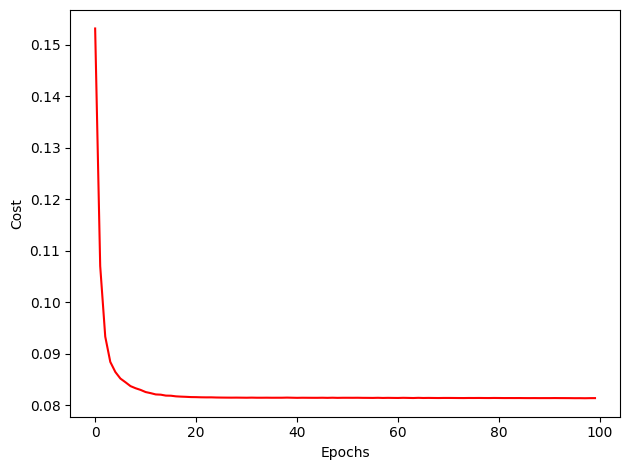

CPU times: total: 812 ms
Wall time: 1.39 s


In [11]:
%%time
params['epochs'] = 100
params['eta'] = 0.1
nn_mini = TLPVectorizedMiniBatch(**params,
                          alpha=0.1,# momentum calculation
                          decrease_const=0.1, # decreasing eta
                          minibatches=len(X_train)/32, # minibatch size
                          shuffle=True)

    
nn_mini.fit(X_train, y_train, print_progress=50)
yhat = nn.predict(X_test)
print('Accuracy:',accuracy_score(y_test,yhat))

# take the mean of each minibatch epoch
cost_avgs = [np.mean(x) for x in nn_mini.cost_]

plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

In [36]:
class ThreeLayerPerceptron(TLPVectorizedMiniBatch):
    def _cost(self, A4, Y_enc, W1, W2, W3):
        '''Get the objective function value using cross-entropy loss.'''
        m = Y_enc.shape[1]
        cost = -1/m * np.sum(Y_enc * np.log(A4))
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3)
        return cost + L2_term

    def _L2_reg(self, lambda_, W1, W2, W3):
        """Compute L2-regularization cost for three layers"""
        return (lambda_) * (np.mean(W1 ** 2) + np.mean(W2 ** 2) + np.mean(W3 ** 2))

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        init_bound = np.sqrt(6. / (self.n_features_ + self.n_hidden))
        W1 = np.random.uniform(-init_bound, init_bound, (self.n_hidden, self.n_features_))
        b1 = np.zeros((self.n_hidden, 1))
        
        init_bound = np.sqrt(6. / (2 * self.n_hidden))
        W2 = np.random.uniform(-init_bound, init_bound, (self.n_hidden, self.n_hidden))
        b2 = np.zeros((self.n_hidden, 1))
        
        init_bound = np.sqrt(6. / (self.n_hidden + self.n_output_))
        W3 = np.random.uniform(-init_bound, init_bound, (self.n_output_, self.n_hidden))
        b3 = np.zeros((self.n_output_, 1))

        return W1, W2, W3, b1, b2, b3

    def _feedforward(self, X, W1, W2, W3, b1, b2, b3):
        """Compute feedforward step including third layer"""
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        Z3 = W3 @ A3 + b3
        A4 = np.exp(Z3) / np.sum(np.exp(Z3), axis=0)

        return A1, Z1, A2, Z2, A3, Z3, A4

    def _get_gradient(self, A1, A2, A3, A4, Z1, Z2, Z3, Y_enc, W1, W2, W3):
        """ Compute gradient step using backpropagation including third layer."""
        V3 = A4 - Y_enc
        V2 = A3 * (1 - A3) * (W3.T @ V3)
        V1 = A2 * (1 - A2) * (W2.T @ V2)

        gradW3 = V3 @ A3.T
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T

        gradb3 = np.sum(V3, axis=1).reshape((-1, 1))
        gradb2 = np.sum(V2, axis=1).reshape((-1, 1))
        gradb1 = np.sum(V1, axis=1).reshape((-1, 1))

        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C * 2
        gradW2 += W2 * self.l2_C * 2 
        gradW3 += W3 * self.l2_C * 2 

        return gradW1, gradW2, gradW3, gradb1, gradb2, gradb3

    def fit(self, X, y, print_progress=0):
        """ Learn weights from training data."""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.b1, self.b2, self.b3 = self._initialize_weights()
        
        # start momentum at zero for previous updates
        rho_W1_prev = np.zeros(self.W1.shape)
        rho_W2_prev = np.zeros(self.W2.shape)
        rho_W3_prev = np.zeros(self.W3.shape)

        # Initiate lists to save gradient magnitudes and costs
        self.grad_avg_mag_W1_ = []
        self.grad_avg_mag_W2_ = []
        self.grad_avg_mag_W3_ = []
        grad_mags_W1 = []
        grad_mags_W2 = []
        grad_mags_W3 = []
        self.cost_ = []

        for k in range(self.epochs):
            if print_progress > 0 and (k+1) % print_progress == 0:
                sys.stderr.write('\rEpoch: %d/%d' % (k+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                ridx = np.random.permutation(y_data.shape[0])
                X_data, Y_enc = X_data[ridx], Y_enc[:, ridx]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []  # list to store cost for each mini-batch
            for idx in mini:
                A1, Z1, A2, Z2, A3, Z3, A4 = self._feedforward(X_data[idx], self.W1, self.W2, self.W3, self.b1, self.b2, self.b3)
                
                # Compute cost
                cost = self._cost(A4, Y_enc[:, idx], self.W1, self.W2, self.W3)
                mini_cost.append(cost)
                
                # Compute gradient via backpropagation
                gradW1, gradW2, gradW3, gradb1, gradb2, gradb3 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, Z1=Z1, Z2=Z2, Z3=Z3, Y_enc=Y_enc[:, idx], W1=self.W1, W2=self.W2, W3=self.W3)
                
                # Update weights
                rho_W1, rho_W2, rho_W3 = self.eta * gradW1, self.eta * gradW2, self.eta * gradW3
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev))
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev))
                self.W3 -= (rho_W3 + (self.alpha * rho_W3_prev))
                rho_W1_prev, rho_W2_prev, rho_W3_prev = rho_W1, rho_W2, rho_W3
                
                self.b1 -= self.eta * gradb1 
                self.b2 -= self.eta * gradb2
                self.b3 -= self.eta * gradb3

                # Store gradient magnitudes for this mini-batch
                grad_mags_W1.append(np.mean(np.abs(gradW1)))
                grad_mags_W2.append(np.mean(np.abs(gradW2)))
                grad_mags_W3.append(np.mean(np.abs(gradW3)))

            # Compute and store gradient magnitudes
            self.grad_avg_mag_W1_.append(np.mean(grad_mags_W1))
            self.grad_avg_mag_W2_.append(np.mean(grad_mags_W2))
            self.grad_avg_mag_W3_.append(np.mean(grad_mags_W3))

            self.cost_.append(np.mean(mini_cost))  # append average cost of the epoch

        return self

    def plot_gradient_magnitudes(self):
        """Plot the magnitude of the gradients for each layer for every epoch."""
        plt.plot(self.grad_avg_mag_W1_, label='Layer 1', color='blue')
        plt.plot(self.grad_avg_mag_W2_, label='Layer 2', color='green')
        plt.plot(self.grad_avg_mag_W3_, label='Layer 3', color='red')
        plt.ylabel('Average Gradient Magnitude')
        plt.xlabel('Epochs')
        plt.legend(loc='upper right')
        plt.tight_layout()
        plt.show()

Epoch: 100/100

Accuracy: 0.9611111111111111


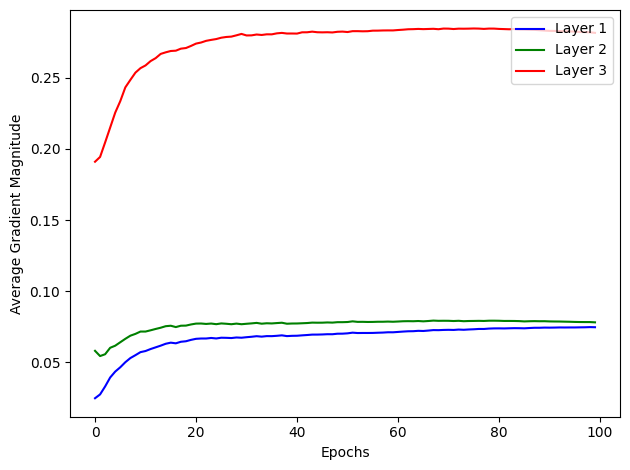

CPU times: total: 2.45 s
Wall time: 3.47 s


In [37]:
%%time
params['epochs'] = 100
params['eta'] = 0.1
nn_mini = ThreeLayerPerceptron(**params,
                          alpha=0.1,# momentum calculation
                          decrease_const=0.1, # decreasing eta
                          minibatches=len(X_train)/32, # minibatch size
                          shuffle=True)

nn_mini.fit(X_train, y_train, print_progress=50)
yhat = nn.predict(X_test)
print('Accuracy:',accuracy_score(y_test,yhat))

nn_mini.plot_gradient_magnitudes()